## Modules à importer

In [1]:
import math
import scipy
import pickle
import sncosmo
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from variaIa import baserate
from variaIa import stretchevol
from scipy.stats import poisson
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import random

## Définitions et sélection de l'échantillon à utiliser

In [2]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col='CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv', sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value='PS1')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

def set_data(su):
    global dataz, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
    else:
        dataz = np.sort(surv[su].zCMB.values)
    
int_data = ipw.interactive(set_data, su=su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

# Détermination des $z_{\text{max}}$ _via_ SNcosmo

In [3]:
model = sncosmo.Model(source="salt2")
model.set(z=.1, t0=55000., x1=1., c=0.1)
model.cosmo = Planck15
model.set_source_peakabsmag(-19.3, 'bessellb', 'ab', 1.0, Planck15)

In [4]:
model.bandmag('bessellb', 'ab', [54990., 55000., 55020.]) - model.cosmo.distmod(model['z']).value

array([-18.69176037, -19.20817641, -17.71643999])

In [5]:
Planck15.distmod(model["z"]).value

38.38500782579381

In [6]:
model = sncosmo.Model("salt2")
model.set(z=0.00000001, t0=55000, c=0., x1=0)
model.set_source_peakabsmag(-19.3, "bessellb", "ab", cosmo=Planck15)
model.update({"c":0.2})
model.bandmag('bessellb', 'ab', model["t0"]-5) - Planck15.distmod(model["z"]).value

-19.1459702214552

In [10]:
M_list = []
model = sncosmo.Model("salt2")
model.set(z=0.00000001, t0=55000, c=0., x1=0)
model.set_source_peakabsmag(-19.3, "bessellb", "ab", cosmo=Planck15)

a=3.     #radius on the x-axis
b=.3    #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)

data = dict()

for i in range(len(t)):
    data[i] = {'c': b*np.sin(t)[i],
                  'x1': a*np.cos(t)[i]}
    model.update(data[i])
    data[i]['M'] = model.bandmag('bessellb', 'ab', model["t0"]-5) - Planck15.distmod(model["z"]).value

In [11]:
df = pd.DataFrame(data).T
df['M_eff'] = df['M']-0.141*df['x1']+3.15*df['c']

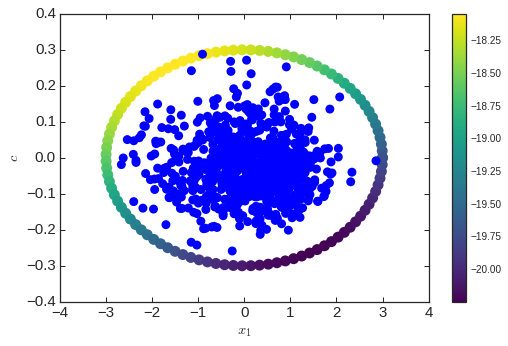

In [12]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ts = ax.scatter(df['x1'],
                df['c'],
                marker='o',
                cmap='viridis',
                c=df['M_eff'], edgecolors="None",
                s=20,
                zorder=2)

fig.colorbar(ts, label=r'$M$ (mag)')

for survey in surveys[1:-1]:
    ax.scatter(surv[survey].x1,
               surv[survey].c,
               marker='o',
               fc=plt.cm.binary(.5, .5),
               edgecolors="k",
               lw=.5,
               s=80,
               zorder=2)
    ax.errorbar(surv[survey].x1,
                surv[survey].c,
                xerr=surv[survey].x1ERR,
                yerr=surv[survey].cERR,
                marker='None',
                ls="None",
                zorder=1,
                ecolor=".7")

ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)

ax.set_xlabel(r'SALT2.4 $x_1$', fontsize='large')
ax.set_ylabel(r'SALT2.4 $c$', fontsize='large')

ax.set_xlim(-4, 4)
ax.set_ylim(-.4, .4)

# plt.legend(ncol=1, loc='upper left', fontsize='x-large')
fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/ellipse_zmax_PS1.pdf')

In [ ]:
df.sort_values('M_eff', ascending=False).iloc[0]['M_eff']

In [ ]:
21.8-df.sort_values('M_eff', ascending=False).iloc[0]['M_eff']

In [ ]:
Planck15.distmod(0.18)

In [ ]:
with open('../Data/zmax_spec_result', 'rb') as f:
    z_lins, meds, stds, z_max, itsc = pickle.load(f)

In [ ]:
z_max

In [ ]:
from scipy import optimize

In [ ]:
def find_zmax(mag_lim, magabs_lim=-18.):
    return(find_z(mag_lim - magabs_lim))

def find_z(distmod, cosmo=None):
    if cosmo is None:
        from astropy.cosmology import Planck15
        cosmo = Planck15
    return(optimize.fmin(lambda z: np.abs(cosmo.distmod(z).value - distmod), 0.1, disp=0))

In [ ]:
find_zmax(24.5)

In [4]:
bp = sncosmo.get_bandpass('bessellb')

In [5]:
bp.wave_eff*1.3

5700.204554795735

In [6]:
sncosmo.get_bandpass('sdssr').wave_eff

6186.798254522246